In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
from functools import partial
from math import log2
from time import perf_counter
from typing import Literal, cast

import jax
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from tqdm.auto import tqdm

from ising_mcmc.cpu.fm import sweeps as sweeps_cpu
from ising_mcmc.cuda.fm import sweeps as sweeps_cuda
from ising_mcmc.jax.fm import sweeps as sweeps_jax
from ising_mcmc.pallas.fm import sweeps as sweeps_pallas

In [3]:
type Version = Literal["cpu", "cuda", "jax", "pallas"]


def nearest_power_of_2(n):
    return 2 ** round(log2(n))


def measure_wall_time(
    version: Version,
    ndim: int,
    size: int,
    n_sweeps: int,
    temperatures: NDArray[np.float32],
    seed: int,
):
    rng = np.random.default_rng(seed)

    spin = rng.integers(
        0, 2, size=(len(temperatures), *(ndim * (size,))), dtype=np.int32
    )
    spin = 2 * spin - 1

    h_ext = np.zeros_like(spin, np.float32)

    t0 = perf_counter()

    if version == "cpu":
        sweeps_cpu(spin, h_ext, temperatures, n_sweeps, seed)
    elif version == "cuda":
        sweeps_cuda(spin, h_ext, temperatures, n_sweeps, seed)
    elif version == "jax":
        keys_by_temp = jax.random.split(
            jax.random.key(seed), (len(temperatures), n_sweeps)
        )
        result = jax.vmap(sweeps_jax)(keys_by_temp, spin, h_ext, temperatures)
        jax.block_until_ready(result)
    elif version == "pallas":
        keys_by_temp = jax.random.split(
            jax.random.key(seed), (len(temperatures), n_sweeps)
        )
        tile_size = nearest_power_of_2(256 ** (1 / ndim))
        result = jax.jit(jax.vmap(partial(sweeps_pallas, tile_size=tile_size)))(
            keys_by_temp, spin, h_ext, temperatures
        )
        jax.block_until_ready(result)
    else:
        raise ValueError(f"unknown version: {version}")

    t1 = perf_counter()

    return t1 - t0

In [4]:
temperatures = np.array([2.26, 2.27, 2.28], dtype=np.float32)

params_tuples: list[tuple[Version, int, int, int]] = [
    (cast(Version, version), ndim, size, seed)
    for version in [
        "cpu",
        "cuda",
        "jax",
        "pallas",
    ]
    for ndim, size in [
        (2, 32),
        (2, 48),
        (2, 64),
        (2, 96),
        (2, 128),
        (2, 192),
        (2, 256),
        (3, 8),
        (3, 12),
        (3, 16),
        (3, 24),
        (3, 32),
        (3, 40),
        (4, 6),
        (4, 7),
        (4, 8),
        (4, 10),
        (4, 12),
        (4, 14),
        (4, 16),
    ]
    if not (version == "cpu" and size**ndim > 2**16)
    for seed in range(5)
]


results = pd.DataFrame.from_records(
    [
        (version, ndim, size, seed, wall_time)
        for version, ndim, size, seed in tqdm(params_tuples)
        for wall_time in [
            measure_wall_time(
                version,
                ndim,
                size,
                1_000,
                temperatures,
                seed,
            )
        ]
    ],
    columns=[
        "version",
        "ndim",
        "size",
        "seed",
        "wall_time",
    ],
).set_index(["version", "ndim", "size", "seed"])

  0%|          | 0/400 [00:00<?, ?it/s]

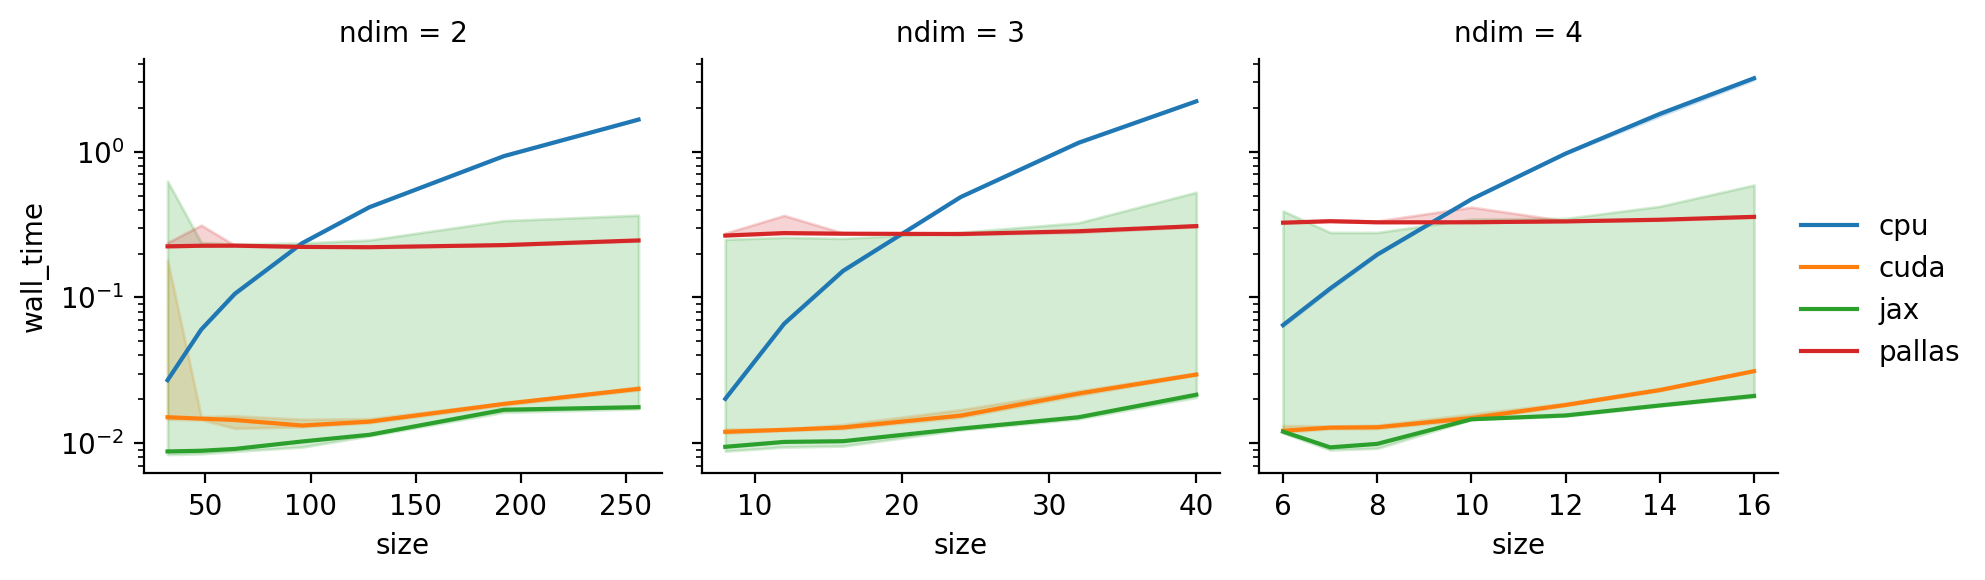

In [5]:
sns.FacetGrid(results.reset_index(), col="ndim", sharex=False).map_dataframe(
    sns.lineplot, x="size", y="wall_time", hue="version", estimator="median"
).set(yscale="log").add_legend()

In [6]:
results.unstack("version")

wall_time                              
version              cpu      cuda       jax    pallas
ndim size seed                                        
2    32   0     0.027311  0.180406  0.627733  0.238111
          1     0.026866  0.014576  0.009813  0.223535
          2     0.027237  0.015075  0.008351  0.222266
          3     0.026947  0.015102  0.008514  0.224367
          4     0.027063  0.015016  0.008778  0.224778
...                  ...       ...       ...       ...
4    16   0     3.195189  0.031415  0.591243  0.357472
          1     3.230754  0.031213  0.021335  0.359766
          2     3.227609  0.031081  0.020720  0.353524
          3     3.164150  0.031082  0.021078  0.353729
          4     3.123192  0.031523  0.021105  0.359275

[100 rows x 4 columns]